In [126]:
# Created on Feb 2020
# Author: 임일

import numpy as np
import pandas as pd

# 필요한 Surprise 알고리즘 불러오기
from surprise import BaselineOnly 
from surprise import KNNWithMeans, KNNBaseline
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split

In [74]:
# csv 파일에서 불러오기
# r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings_df = pd.read_csv('./../../../data/rotten_tomato/final_rating(sentiment,emotion).csv')

In [75]:
ratings_df = ratings_df[['user_id', 'movie_id', 'review_score']]

In [76]:
ratings_df['rating'] = ratings_df.review_score * 4.5 + 0.5

In [77]:
ratings_df.head()

,user_id,movie_id,review_score,rating
0,943,0,0.70,3.650
1,7242,0,0.25,1.625
2,1046,0,0.70,3.650
3,4895,0,0.70,3.650
4,4517,0,0.60,3.200


### 1. 100개 이상의 리뷰 남긴 User

In [78]:
group = ratings_df.groupby('user_id')
group_user_id = group['movie_id'].count()

In [84]:
def cal_rate(num, total, limit, condition):
    if condition == 'low':
        print(f"{limit}개 미만: {sum(num < limit)}, {round((sum(num < limit)/total),2)*100}%")
        return sum(num >= limit)
    
    if condition == 'high':
        print(f"{limit}개 이상: {sum(num >= limit)}, {round((sum(num > limit)/total),2)*100}%")
        return sum(num >= limit)

In [85]:
num = group_user_id.sort_values()
total = len(group_user_id)

condition = 'high'
sample_num = cal_rate(num, total, 100, condition)
# sample_num = cal_rate(num, total, 500, condition)

100개 이상: 1343, 14.000000000000002%


In [86]:
group_user_id.sort_values(ascending=False)[:5]

user_id
2600    6486
8148    6356
3265    5300
2495    5212
3926    4548
Name: movie_id, dtype: int64

In [87]:
sample = group_user_id.sort_values(ascending=False)[:sample_num]
total = len(group_user_id)

In [88]:
len(sample)

1343

In [89]:
sample.index

Int64Index([2600, 8148, 3265, 2495, 3926, 5446, 5716, 7603, 7917, 1738,
            ...
            6083, 6538, 6594, 8605,  553, 7952, 4521, 6522,   41, 2035],
           dtype='int64', name='user_id', length=1343)

In [90]:
# 특정 인덱스에 해당하는 행만 필터링
ratings_df.loc[sample.index,:]

,user_id,movie_id,review_score,rating
user_id,,,,
2600,6155,86,0.700,3.6500
8148,7607,212,0.500,2.7500
3265,4249,105,0.625,3.3125
2495,3643,85,0.500,2.7500
3926,865,125,1.000,5.0000
...,...,...,...,...
7952,6613,207,0.600,3.2000
4521,8224,138,0.625,3.3125
6522,7126,173,0.400,2.3000


In [91]:
df = ratings_df.loc[sample.index,:]

In [92]:
reader = Reader(rating_scale=(0.5,5))
data = Dataset.load_from_df(df[['user_id', 'movie_id', 'rating']], reader)

# Train/Test 분리 
trainset, testset = train_test_split(data, test_size=0.25)

In [93]:
# 정확도 계산 
algo = KNNWithMeans()
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0822


1.0822288965312163

### 0. Timer

In [94]:
import time
import datetime

In [95]:
# 시간 표시 함수
def format_time(elapsed):
    # 반올림
    elapsed_rounded = int(round((elapsed)))
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [96]:
start_time = time.time()
print("  Training epoch took: {:}".format(format_time(time.time() - start_time)))

  Training epoch took: 0:00:00


### 1. Algorithms

In [144]:
start_time = time.time()

# 알고리즘 비교
algorithms = [SVD, SVDpp]
names = []
results = []
for option in algorithms:
    algo = option()
    names.append(option.__name__)       # 알고리즘 이름 
    algo.fit(trainset)
    predictions = algo.test(testset)
    results.append(accuracy.rmse(predictions))
# names = np.array(names)
# results = np.array(results)

print("  Training epoch took: {:}".format(format_time(time.time() - start_time)))

RMSE: 0.8250
RMSE: 0.8051
  Training epoch took: 0:00:00


- Item-based

In [145]:
# 알고리즘 옵션 변경, 정확도 계산
names.append('CF(Item-based)')
sim_options = {'name': 'pearson_baseline',
               'user_based': False}
algo = KNNBaseline(k=30, sim_options=sim_options)
algo.fit(trainset)
predictions = algo.test(testset)
results.append(accuracy.rmse(predictions))

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.8335


- User-based

In [146]:
# 알고리즘 옵션 변경, 정확도 계산
names.append('CF(User-based)')
sim_options = {'name': 'pearson_baseline',
               'user_based': True}
algo = KNNBaseline(k=30, sim_options=sim_options)
algo.fit(trainset)
predictions = algo.test(testset)
results.append(accuracy.rmse(predictions))

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.8182


In [147]:
names = np.array(names)
results = np.array(results)

array([0.80512462, 0.81820464, 0.82498468, 0.83354265])

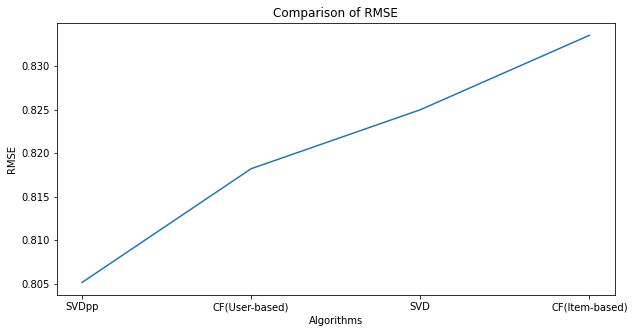

In [148]:
# 결과를 그래프로 표시
import matplotlib.pyplot as plt
index = np.argsort(results)
# plt.ylim(0.5, 0.8)
fig = plt.figure(figsize = (10,5))
plt.plot(names[index], results[index])
plt.xlabel('Algorithms')
plt.ylabel('RMSE')
plt.title('Comparison of RMSE')
results[index]

### 2. MF

- SVD

In [102]:
start_time = time.time()

algo = SVD()
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

print("  Training epoch took: {:}".format(format_time(time.time() - start_time)))

RMSE: 0.8201
  Training epoch took: 0:00:00


- SVD++

In [103]:
start_time = time.time()

algo = SVDpp()
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

print("  Training epoch took: {:}".format(format_time(time.time() - start_time)))

RMSE: 0.8077
  Training epoch took: 0:00:00
